In [15]:
import pandas as pd
import dask.dataframe as dd
import dask
import numpy as np
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import tqdm

gc.collect()

0

In [16]:
train_path = '/kaggle/input/smadex-challenge-predict-the-revenue/train/train'
test_path = '/kaggle/input/smadex-challenge-predict-the-revenue/test/test'

In [17]:
# Definir columnas necesarias
required_columns = [
    'row_id', 'datetime',
    'buyer_d7', 'iap_revenue_d7',
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
    'advertiser_bottom_taxonomy_level',
    'country', 'region',
    'dev_make', 'dev_model', 'dev_os', 'dev_osv',
    'carrier',
    'hour', 'weekday', 'weekend_ratio', 'hour_ratio',
    'release_date', 'release_msrp',
    'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration',
    'weeks_since_first_seen', 'wifi_ratio',
    'retentiond7',
    'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist',
    'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk',
    'iap_revenue_usd_bundle', 'iap_revenue_usd_category',
    'num_buys_bundle', 'num_buys_category',
    'last_buy', 'last_ins',
    'bcat', 'bcat_bottom_taxonomy',
    'bundles_cat', 'bundles_cat_bottom_taxonomy', 
    'bundles_ins',
    'new_bundles', 'user_bundles', 'user_bundles_l28d',
    'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_count', 'user_actions_bundles_action_last_timestamp',
    'last_advertiser_action',
    'first_request_ts', 'first_request_ts_bundle', 
    'first_request_ts_category_bottom_taxonomy',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# Cargar datos (10% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
num_files_train = max(1, int(len(parquet_files_train) * 0.10))
parquet_files_train = parquet_files_train[:num_files_train]

try:
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow', columns=required_columns)
    print(f"✓ Train cargado con {num_files_train} archivos")
except Exception as e:
    print(f"⚠️ Cargando todas las columnas: {e}")
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')

# Computar a Pandas
train_df = train_ddf.compute(scheduler='synchronous')
print(f"✓ Train shape: {train_df.shape}")

✓ Train cargado con 14 archivos
✓ Train shape: (1821893, 62)


In [18]:
# Preprocesar columnas con listas - SUMAR todos los valores
import ast

columns_to_sum = [
    'iap_revenue_usd_bundle',
    'num_buys_bundle',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank',
    'whale_users_bundle_revenue_prank'
]

significant_list_columns = [
    'advertiser_actions_action_count',
    'advertiser_actions_action_last_timestamp',
    'last_buy_ts_category',
    'iap_revenue_usd_category_bottom_taxonomy',
    'num_buys_category_bottom_taxonomy',
    'last_buy_ts_bundle',
    'num_buys_category',
    'iap_revenue_usd_category',
    'rev_by_adv'
]

# Versión in-place (modifica el DataFrame original)
def convert_lists_to_length_inplace(df, list_columns):
    """Convierte columnas tipo lista a su longitud (in-place)"""
    for col in list_columns:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda x: len(x) if isinstance(x, (list, tuple)) and x is not None 
                else (len(eval(x)) if isinstance(x, str) and x.strip() else 0)
            )
            print(f"✓ {col} → longitud")
    return df

print("=" * 60)
print("PREPROCESANDO COLUMNAS CON LISTAS")
print("=" * 60)

def sum_values(x):
    """Suma todos los valores numéricos de la lista"""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    try:
        # Si es string, convertir a lista
        if isinstance(x, str):
            x = ast.literal_eval(x)
        
        # Si es lista de tuplas, sumar el segundo valor de cada tupla
        if isinstance(x, list) and len(x) > 0:
            total = sum([item[1] for item in x if isinstance(item, tuple) and len(item) > 1])
            return total
        return 0
    except:
        return 0

for col in columns_to_sum:
    if col in train_df.columns:
        print(f"\n📊 Procesando {col}...")
        
        # Aplicar transformación
        train_df[col] = train_df[col].apply(sum_values)
        
        # Verificar resultado
        print(f"  ✓ Convertido a numérico")
        print(f"  Tipo nuevo: {train_df[col].dtype}")
        print(f"  Valores ejemplo: {train_df[col].head(3).values}")
        print(f"  Stats: min={train_df[col].min():.4f}, max={train_df[col].max():.4f}, mean={train_df[col].mean():.4f}")
    else:
        print(f"\n❌ {col} - NO ENCONTRADA")

convert_lists_to_length_inplace(train_df, significant_list_columns)

print("\n" + "=" * 60)
print("✓ PREPROCESAMIENTO COMPLETADO")
print("=" * 60)

PREPROCESANDO COLUMNAS CON LISTAS

📊 Procesando iap_revenue_usd_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=525041.6100, mean=5.6900

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=5648.0000, mean=0.5882

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [1.69256776 0.         3.78493692]
  Stats: min=0.0000, max=13.2584, mean=0.6133

📊 Procesando whale_users_bundle_num_buys_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=16.6758, mean=0.0181

📊 Procesando whale_users_bundle_revenue_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=-0.6749, max=6.2643, mean=0.0064
✓ advertiser_actions_action_count → longitud
✓ advertiser_actions_action_last_timestamp → longitud
✓ num_buys_category →

In [19]:
# Definir features categóricas
cat_features = [
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory',
    'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv'
]

labels_to_exclude = [
    'buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28',
    'buy_d7', 'buy_d14', 'buy_d28',
    'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28',
    'registration', 'retention_d1_to_d7', 'retention_d3_to_d7',
    'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retention_d7',
    'row_id', 'datetime',
    'user_actions_bundles_action_last_timestamp',
    'first_request_ts', 'first_request_ts_bundle',
    'first_request_ts_category_bottom_taxonomy'
]


from sklearn.preprocessing import LabelEncoder, StandardScaler

# Asegurarte de que solo usas columnas categóricas que existen
cat_features = [c for c in cat_features if c in train_df.columns]

# Label Encoding para categorías
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str).fillna("__NA__"))
    label_encoders[col] = le

# Features numéricas
numeric_features = [
    c for c in train_df.columns
    if c not in labels_to_exclude
    and c not in cat_features
    and train_df[c].dtype in ['int64', 'int32', 'int16', 'int8', 'float32', 'float64']
]

# Normalización de las numéricas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])


# Features finales
features = numeric_features + cat_features
print(f"Total features: {len(features)}")

Total features: 28


In [20]:
# Split temporal - validación solo del día 2025-10-06
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))

# Usar solo el día 2025-10-06 para validación
val_date = pd.Timestamp('2025-10-06', tz='UTC')
val_mask = train_df['datetime'].dt.date == val_date.date()

X_train = train_df[~val_mask][features]
X_val = train_df[val_mask][features]

# Target
y_train = train_df[~val_mask]['iap_revenue_d7']
y_val = train_df[val_mask]['iap_revenue_d7']

# Transform con log1p
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f"Fecha máxima dataset: {train_df['datetime'].max()}")
print(f"Fecha validación: {val_date.date()}")
print(f"Train: {len(X_train):,} samples ({train_df[~val_mask]['datetime'].min()} a {train_df[~val_mask]['datetime'].max()})")
print(f"Val: {len(X_val):,} samples ({train_df[val_mask]['datetime'].min()} a {train_df[val_mask]['datetime'].max()})")
print(f"Val es solo día 2025-10-06: {train_df[val_mask]['datetime'].dt.date.nunique() == 1}")

/tmp/ipykernel_330/2954038451.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Fecha máxima dataset: 2025-10-06 21:00:00+00:00
Fecha validación: 2025-10-06
Train: 1,185,989 samples (2025-10-01 00:00:00+00:00 a 2025-10-04 23:00:00+00:00)
Val: 635,904 samples (2025-10-06 00:00:00+00:00 a 2025-10-06 21:00:00+00:00)
Val es solo día 2025-10-06: True


In [21]:
# Preprocesar datos
for col in X_train.select_dtypes(include=['object']).columns:
    if col not in cat_features:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

print("✓ Datos preprocesados")

✓ Datos preprocesados


In [22]:
# PARÁMETROS OPTIMIZADOS
params_optimized = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.02,
    'num_leaves': 50,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

print("=" * 60)
print("ENTRENANDO MODELO OPTIMIZADO")
print("=" * 60)
print("Parámetros:")
print(f"  Learning rate: {params_optimized['learning_rate']}")
print(f"  Num leaves: {params_optimized['num_leaves']}")
print(f"  Max depth: {params_optimized['max_depth']}")
print(f"  Min data in leaf: {params_optimized['min_data_in_leaf']}")
print("=" * 60)

ENTRENANDO MODELO OPTIMIZADO
Parámetros:
  Learning rate: 0.02
  Num leaves: 50
  Max depth: -1
  Min data in leaf: 20


In [23]:
# Entrenar modelo
cat_features_valid = [col for col in cat_features if col in features]

train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

model = lgb.train(
    params_optimized,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print(f"\n✓ Modelo entrenado ({model.best_iteration} iteraciones)")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	training's rmse: 0.38665	valid_1's rmse: 0.408001

✓ Modelo entrenado (366 iteraciones)


In [24]:
# Evaluar en validación
pred_log = model.predict(X_val)
pred = np.expm1(pred_log).clip(0, None)

msle = mean_squared_log_error(y_val, pred)
rmse = mean_squared_error(y_val, pred)

print("=" * 60)
print("RESULTADOS EN VALIDACIÓN")
print("=" * 60)
print(f"MSLE: {msle:.6f}")
print(f"RMSE: ${rmse:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

RESULTADOS EN VALIDACIÓN
MSLE: 0.166456
RMSE: $3458.91
Revenue promedio predicho: $0.12
Revenue promedio real: $1.07


In [25]:
"""# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS
from sklearn.model_selection import ParameterGrid
import time

print("=" * 60)
print("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 60)

# Definir grid de parámetros
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 15],
    'min_data_in_leaf': [20, 50, 100],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9]
}

# Base params
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Preparar datasets
cat_features_valid = [col for col in cat_features if col in features]
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

# Grid search
results = []
best_score = float('inf')
best_params = None

grid = list(ParameterGrid(param_grid))
print(f"\nTotal combinaciones a probar: {len(grid)}")
print("Probando combinaciones (esto puede tardar)...\n")

for i, params in enumerate(grid[:20], 1):  # Limitar a 20 combinaciones para no tardar mucho
    print(f"[{i}/20] Probando: lr={params['learning_rate']}, leaves={params['num_leaves']}, depth={params['max_depth']}")
    
    # Combinar params
    current_params = {**base_params, **params}
    
    # Entrenar
    start_time = time.time()
    model_temp = lgb.train(
        current_params,
        train_ds,
        num_boost_round=500,  # Reducido para grid search
        valid_sets=[val_ds],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    elapsed = time.time() - start_time
    
    # Evaluar
    pred_log = model_temp.predict(X_val)
    pred = np.expm1(pred_log).clip(0, None)
    msle = mean_squared_log_error(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    
    # Guardar resultado
    results.append({
        **params,
        'msle': msle,
        'rmse': rmse,
        'best_iteration': model_temp.best_iteration,
        'time': elapsed
    })
    
    print(f"  ✓ MSLE: {msle:.6f} | RMSE: {rmse:.2f} | Iters: {model_temp.best_iteration} | Time: {elapsed:.1f}s")
    
    # Actualizar mejor
    if msle < best_score:
        best_score = msle
        best_params = params
        print(f"  🎯 NUEVO MEJOR SCORE!")
    
    print()

# Mostrar resultados
print("=" * 60)
print("RESULTADOS GRID SEARCH")
print("=" * 60)

results_df = pd.DataFrame(results).sort_values('msle')
print("\nTop 5 mejores combinaciones:")
print(results_df.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("MEJORES PARÁMETROS ENCONTRADOS:")
print("=" * 60)
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nMejor MSLE: {best_score:.6f}")
print("=" * 60)

# Entrenar modelo final con mejores params
print("\nEntrenando modelo final con mejores parámetros...")
final_params = {**base_params, **best_params}

model_final = lgb.train(
    final_params,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print(f"✓ Modelo final entrenado ({model_final.best_iteration} iteraciones)")

# Evaluar modelo final
pred_log = model_final.predict(X_val)
pred = np.expm1(pred_log).clip(0, None)
msle_final = mean_squared_log_error(y_val, pred)
rmse_final = np.sqrt(mean_squared_error(y_val, pred))

print("\n" + "=" * 60)
print("RESULTADOS FINALES CON MEJORES PARÁMETROS")
print("=" * 60)
print(f"MSLE: {msle_final:.6f}")
print(f"RMSE: ${rmse_final:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

# Guardar modelo final
model = model_final"""

'# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS\nfrom sklearn.model_selection import ParameterGrid\nimport time\n\nprint("=" * 60)\nprint("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")\nprint("=" * 60)\n\n# Definir grid de parámetros\nparam_grid = {\n    \'learning_rate\': [0.01, 0.03, 0.05],\n    \'num_leaves\': [31, 63, 127],\n    \'max_depth\': [-1, 10, 15],\n    \'min_data_in_leaf\': [20, 50, 100],\n    \'feature_fraction\': [0.7, 0.8, 0.9],\n    \'bagging_fraction\': [0.7, 0.8, 0.9]\n}\n\n# Base params\nbase_params = {\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    \'bagging_freq\': 5,\n    \'verbose\': -1,\n    \'device\': \'cpu\'\n}\n\n# Preparar datasets\ncat_features_valid = [col for col in cat_features if col in features]\ntrain_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)\nval_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)\n\n# Grid search\nresults = []\nbest_score = float(\'inf\')\nbest_params = None

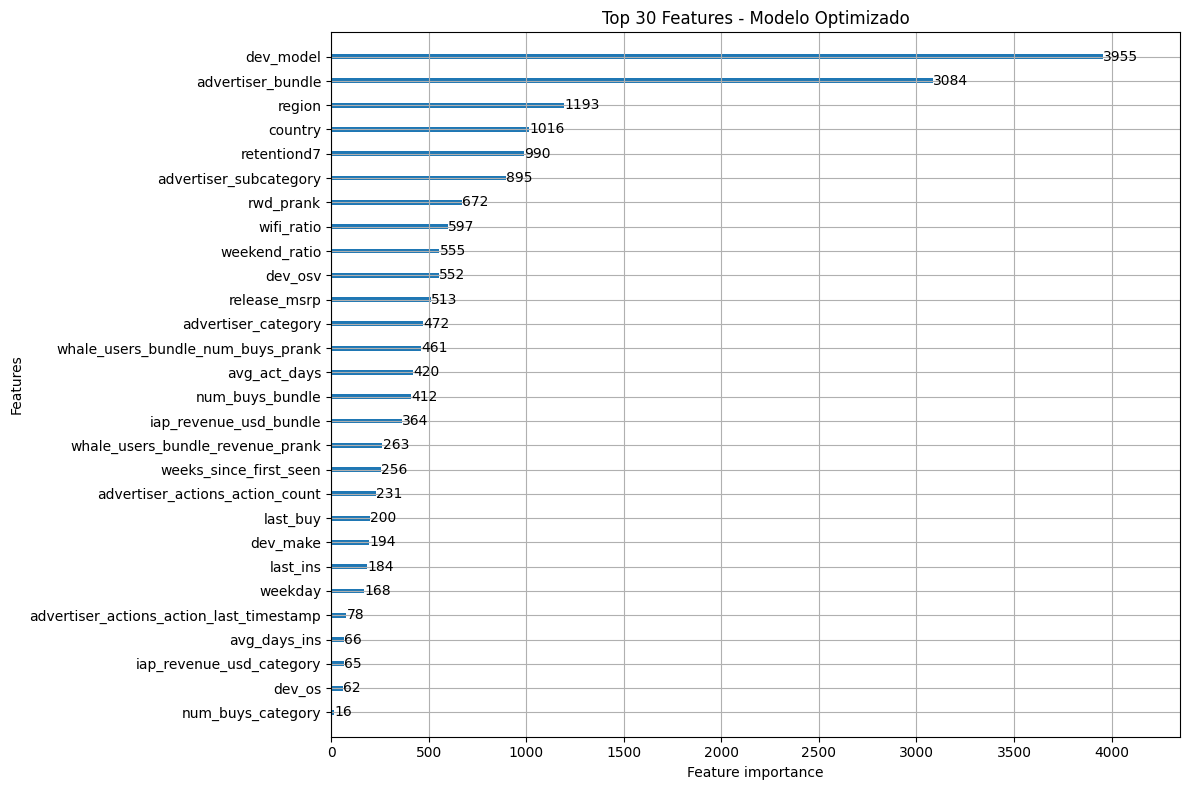

In [26]:
# Feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=30, ax=ax, title='Top 30 Features - Modelo Optimizado')
plt.tight_layout()
plt.show()

In [27]:
import ast
import dask.dataframe as dd

def convert_length_partition(partition, list_columns):
    def safe_length(x):
        if isinstance(x, (list, tuple)) and x is not None:
            return len(x)
        elif isinstance(x, str) and x.strip():
            try:
                parsed = ast.literal_eval(x)
                if isinstance(parsed, (list, tuple)):
                    return len(parsed)
            except (ValueError, SyntaxError):
                pass
        return 0
    
    for col in list_columns:
        if col in partition.columns:
            partition[col] = partition[col].apply(safe_length)
    return partition

def convert_lists_to_length_inplace2(df, list_columns):
    # Caso 1: Dask DataFrame
    if isinstance(df, dd.DataFrame):
        return df.map_partitions(
            convert_length_partition,
            list_columns=list_columns,
            meta=df._meta
        )
    # Caso 2: pandas DataFrame
    else:
        return convert_length_partition(df, list_columns)

significant_list_columns = [
    'advertiser_actions_action_count',
    'advertiser_actions_action_last_timestamp',
    'last_buy_ts_category',
    'iap_revenue_usd_category_bottom_taxonomy',
    'num_buys_category_bottom_taxonomy',
    'last_buy_ts_bundle',
    'num_buys_category',
    'iap_revenue_usd_category',
    'rev_by_adv'
    ]


In [ ]:
import gc
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Paths
TEST_PATH = "/kaggle/input/smadex-challenge-predict-the-revenue/test/test"

print("=" * 60)
print("GENERANDO PREDICCIONES EN TEST")
print("=" * 60)

# 1. Cargar test con las columnas necesarias
try:
    dd_test = dd.read_parquet(TEST_PATH, engine='pyarrow', columns=['row_id'] + features)
    print("✓ Test cargado con columnas específicas")
except:
    dd_test = dd.read_parquet(TEST_PATH, engine='pyarrow')
    print("✓ Test cargado con todas las columnas")

# 2. Convertir listas a longitud (como antes)
dd_test = convert_lists_to_length_inplace2(dd_test, significant_list_columns)

# 3. Definir columnas de listas a sumar (igual que en tu código)
columns_to_sum = [
    'iap_revenue_usd_bundle', 'num_buys_bundle', 'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# 4. Preprocesado por partición (esto es básicamente tu bucle, pero sin la parte de predicción)
def preprocess_partition(part_df):
    # Seleccionar y preparar features
    X_part = part_df[[col for col in features if col in part_df.columns]].copy()
    
    # Asegurar que tenga todas las features del entrenamiento
    for col in features:
        if col not in X_part.columns:
            X_part[col] = 0
    
    # Reordenar columnas como en entrenamiento
    X_part = X_part[features]
    
    # Columnas con listas (sumar valores)
    for col in columns_to_sum:
        if col in X_part.columns:
            X_part[col] = X_part[col].apply(
                lambda x: sum(
                    [item[1] for item in x if isinstance(item, tuple) and len(item) > 1]
                ) if isinstance(x, list) else 0
            )
    
    # Label encoding para categóricas
    for col in cat_features:
        if col in X_part.columns:
            X_part[col] = X_part[col].astype(str).fillna("__NA__")
            X_part[col] = X_part[col].map(
                lambda x: label_encoders[col].transform([x])[0]
                if x in label_encoders[col].classes_ else -1
            )
            # NO hacemos astype('category') aquí para evitar problemas con fillna / scaler

    # Convertir numéricas a tipo numérico (por seguridad)
    for col in numeric_features:
        if col in X_part.columns:
            X_part[col] = pd.to_numeric(X_part[col], errors='coerce')
    
    # Aplicar el scaler entrenado en TRAIN sobre los datos de X_part
    X_part[numeric_features] = scaler.transform(X_part[numeric_features])
    
    # Rellenar NaNs solo en numéricas
    X_part[numeric_features] = X_part[numeric_features].fillna(0)

    # Volver a poner las features procesadas en el dataframe original
    part_df[features] = X_part[features]
    return part_df

# 5. Aplicar preprocesamiento a TODO el Dask DataFrame (lazy)
dd_test = dd_test.map_partitions(preprocess_partition)

# 6. Reparticionar y convertir a delayed (igual que antes)
dd_test = dd_test.repartition(npartitions=200)
delayed_parts = dd_test.to_delayed()
print(f"Número de chunks: {len(delayed_parts)}\n")

pred_dfs = []

# 7. Bucle SOLO de predicción
for i, delayed_part in enumerate(delayed_parts, 1):
    print(f"[{i}/{len(delayed_parts)}] Procesando chunk...")
    
    # Computar chunk ya preprocesado
    part_df = delayed_part.compute()
    
    # Guardar row_ids
    row_ids = part_df["row_id"].values
    
    # Ahora las features ya están preprocesadas
    X_part = part_df[features].copy()
    
    # Predecir
    pred_log = model.predict(X_part, num_iteration=model.best_iteration)
    pred = np.expm1(pred_log).clip(0, None)
    
    # Guardar predicciones
    pred_dfs.append(pd.DataFrame({
        "row_id": row_ids,
        "iap_revenue_d7": pred
    }))
    
    print(f"  ✓ {len(row_ids):,} predicciones | Avg revenue: ${pred.mean():.2f}\n")
    
    # Limpiar memoria
    del part_df, X_part, row_ids, pred_log, pred
    gc.collect()

# 8. Concatenar y guardar (igual que antes)
print("=" * 60)
print("FINALIZANDO SUBMISSION")
print("=" * 60)

submission = pd.concat(pred_dfs, ignore_index=True)

# Validaciones
print(f"Total filas: {len(submission):,}")
print(f"Row IDs únicos: {submission['row_id'].nunique():,}")
print(f"Duplicados: {submission['row_id'].duplicated().sum()}")
print(f"NaNs: {submission['iap_revenue_d7'].isna().sum()}")
print(f"\nEstadísticas predicciones:")
print(submission['iap_revenue_d7'].describe())

# Guardar
submission_path = '/kaggle/working/submission.csv'
submission.to_csv(submission_path, index=False)

print(f"\n✓ Guardado en: {submission_path}")
print("=" * 60)

submission.head(10)


GENERANDO PREDICCIONES EN TEST
✓ Test cargado con todas las columnas
Número de chunks: 200

[1/200] Procesando chunk...


In [29]:
# import dask
# import dask.dataframe as dd

# # Paths
# TEST_PATH = "/kaggle/input/smadex-challenge-predict-the-revenue/test/test"

# print("=" * 60)
# print("GENERANDO PREDICCIONES EN TEST")
# print("=" * 60)

# # 1. Cargar test con las columnas necesarias
# try:
#     dd_test = dd.read_parquet(TEST_PATH, engine='pyarrow', columns=['row_id'] + features)
#     print("✓ Test cargado con columnas específicas")
# except:
#     dd_test = dd.read_parquet(TEST_PATH, engine='pyarrow')
#     print("✓ Test cargado con todas las columnas")

# dd_test = convert_lists_to_length_inplace2(dd_test, significant_list_columns)

# # 2. Procesar por chunks
# dd_test = dd_test.repartition(npartitions=200)
# delayed_parts = dd_test.to_delayed()
# print(f"Número de chunks: {len(delayed_parts)}\n")

# pred_dfs = []

# for i, delayed_part in enumerate(delayed_parts, 1):
#     print(f"[{i}/{len(delayed_parts)}] Procesando chunk...")
    
#     # Computar chunk
#     part_df = delayed_part.compute()
    
#     # Guardar row_ids
#     row_ids = part_df["row_id"].values
    
#     # Seleccionar y preparar features
#     X_part = part_df[[col for col in features if col in part_df.columns]].copy()
    
#     # Asegurar que tenga todas las features del entrenamiento
#     for col in features:
#         if col not in X_part.columns:
#             X_part[col] = 0
    
#     # Reordenar columnas como en entrenamiento
#     X_part = X_part[features]
    
#     # Preprocesar igual que en train
#     # Columnas con listas (sumar valores)
#     columns_to_sum = [
#         'iap_revenue_usd_bundle', 'num_buys_bundle', 'rwd_prank',
#         'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
#     ]
    
#     for col in columns_to_sum:
#         if col in X_part.columns:
#             X_part[col] = X_part[col].apply(lambda x: sum([item[1] for item in x if isinstance(item, tuple) and len(item) > 1]) if isinstance(x, list) else 0)
    
#     # Label encoding para categóricas
#     for col in cat_features:
#         if col in X_part.columns:
#             # Usar el mismo encoder del train
#             X_part[col] = X_part[col].astype(str).fillna("__NA__")
#             # Transformar con encoder existente, usar -1 para desconocidos
#             X_part[col] = X_part[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)
#             X_part[col] = X_part[col].astype('category')

    
#     # Convertir numéricas a tipo numérico (por seguridad)
#     for col in numeric_features:
#         if col in X_part.columns:
#             X_part[col] = pd.to_numeric(X_part[col], errors='coerce')
    
#     # Aplicar el scaler entrenado en TRAIN sobre los datos de X_part
#     X_part[numeric_features] = scaler.transform(X_part[numeric_features])
    
#     # Rellenar NaNs si quieres
#     # Fill NaNs only in numeric features
#     X_part[numeric_features] = X_part[numeric_features].fillna(0)


    
#     # Predecir
#     pred_log = model.predict(X_part, num_iteration=model.best_iteration)
#     pred = np.expm1(pred_log).clip(0, None)
    
#     # Guardar predicciones
#     pred_dfs.append(pd.DataFrame({
#         "row_id": row_ids,
#         "iap_revenue_d7": pred
#     }))
    
#     print(f"  ✓ {len(row_ids):,} predicciones | Avg revenue: ${pred.mean():.2f}\n")
    
#     # Limpiar memoria
#     del part_df, X_part, row_ids, pred_log, pred
#     gc.collect()

# # 3. Concatenar y guardar
# print("=" * 60)
# print("FINALIZANDO SUBMISSION")
# print("=" * 60)

# submission = pd.concat(pred_dfs, ignore_index=True)

# # Validaciones
# print(f"Total filas: {len(submission):,}")
# print(f"Row IDs únicos: {submission['row_id'].nunique():,}")
# print(f"Duplicados: {submission['row_id'].duplicated().sum()}")
# print(f"NaNs: {submission['iap_revenue_d7'].isna().sum()}")
# print(f"\nEstadísticas predicciones:")
# print(submission['iap_revenue_d7'].describe())

# # Guardar
# submission_path = '/kaggle/working/submission.csv'
# submission.to_csv(submission_path, index=False)

# print(f"\n✓ Guardado en: {submission_path}")
# print("=" * 60)

# submission.head(10)

GENERANDO PREDICCIONES EN TEST
✓ Test cargado con todas las columnas
Número de chunks: 200

[1/200] Procesando chunk...


TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [ ]:
# Crear submission
submission = pd.DataFrame({
    'row_id': all_row_ids,
    'iap_revenue_d7': all_predictions
})

print("=" * 60)
print("SUBMISSION FINAL")
print("=" * 60)
print(f"Total filas: {len(submission):,}")
print(f"Row IDs únicos: {submission['row_id'].nunique():,}")
print(f"Duplicados: {submission['row_id'].duplicated().sum()}")
print(f"NaN: {submission['iap_revenue_d7'].isna().sum()}")
print(f"\nEstadísticas:")
print(submission['iap_revenue_d7'].describe())

# Guardar
submission_path = 'kaggle/working/submission_optimized.csv'
submission.to_csv(submission_path, index=False)
print(f"\n✓ Guardado en: {submission_path}")
print("=" * 60)